In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image
import re

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
paths = getListOfFiles('data')

In [4]:
videos = []
for path in paths:
    videos.append(re.findall(r'.*/(.*)/.*',path)[0])

#videos = list(set(videos))

In [5]:
#this class for videos that need more than one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.nblocks = 6 #for 720x480 videos
        self.h_steps = 3 #we can fit 3 blocks horizontally
        self.v_steps = 2 #we can fit 2 blocks vertically
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            self.spaths.extend(aux)

    def __len__(self): return (len(self.paths) - self.n_ref)*6
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx_frame = idx//self.nblocks 
        paths = self.spaths[idx_frame:idx_frame+self.n_ref:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(io.imread(path))
                 
        idx_block = idx%self.nblocks #indicates which block I'm trying to predict
                 
        #apply the transforms to the frames         
        if self.tfms: 
            for frame in frames:
                frame = self.tfms(Image.fromarray(frame))
                start_h_mult = idx_block % self.h_steps
                start_v_mult = idx_block % self.v_steps
                frame = frame[:,240*start] #TODO
        
                

In [5]:
#this class for videos that need only one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(288,352),tfms = None,valid=False,valid_pct=0.2):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.valid = valid
        self.valid_pct = valid_pct
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            nframes = len(aux)
            if not self.valid: self.spaths.extend(aux[:int(nframes*(1-self.valid_pct))])
            if self.valid: self.spaths.extend(aux[-int(nframes*(self.valid_pct)):])
            self.spaths.extend(aux)

    def __len__(self): return len(self.spaths) - self.n_ref
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        paths = self.spaths[idx:idx+self.n_ref:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(io.imread(path))
                         
        #apply the transforms to the frames         
        if self.tfms:
            tfms_frames = []
            for frame in frames:
                tfms_frames.append(self.tfms(Image.fromarray(frame)))
        
        sample = (tfms_frames[:self.n_ref],tfms_frames[-1])
        return sample
    
    def show(self,idx):
        
        sample = self.__getitem__(idx)
        imgs = sample[0]
        imgs.append(sample[1])
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,len(sample))
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        for i,frame in enumerate(imgs):
            x = (frame.numpy().transpose((1,2,0))*stds + means)*255
            ax[i].imshow(x.astype(np.uint8))                

In [6]:
tfms = transforms.Compose([
        transforms.CenterCrop((288,352)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #imagenet stats

In [7]:
train_ds = CustomDataset(paths,tfms=tfms,valid=False)
valid_ds = CustomDataset(paths,tfms=tfms,valid=True)

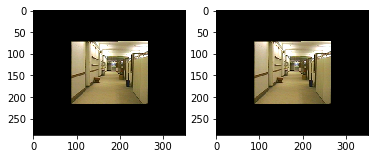

In [8]:
train_ds.show(0)

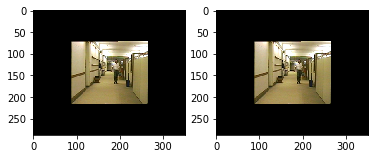

In [9]:
valid_ds.show(0)

In [10]:
train_dl = DataLoader(train_ds,batch_size=4, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=4, shuffle=True, num_workers=2)

In [11]:
data = DataBunch(train_dl,valid_dl)

In [12]:
cnn = models.resnet18(pretrained=True)
cnn_encoder = nn.Sequential(*list(cnn.children())[:-1])
#cnn_encoder = SequentialEx(cnn_encoder)

In [13]:
class Encoder(nn.Module):
    def __init__(self,cnn_encoder,ndims=512):
        super(Encoder,self).__init__()
        self.cnn_encoder = cnn_encoder
        self.lstm = nn.LSTM(ndims,ndims)
        
    def forward(self,x):
        cnn_encodings = [self.cnn_encoder(frame) for frame in x]
        cnn_encodings = torch.cat(cnn_encodings).squeeze(2).transpose(1,2)
        #import pdb;pdb.set_trace()
        out, _ = self.lstm(cnn_encodings)
        #out.orig = x[-1]
        out = out.view(len(out),1,1,-1).transpose(1,3)
        setattr(out,'orig',x[-1])
        return out

In [14]:
encoder = Encoder(cnn_encoder)

In [24]:
x,y = next(iter(train_dl))

In [25]:
bla = encoder(x)
bla.shape

torch.Size([4, 512, 1, 1])

In [17]:
unet = DynamicUnet(nn.Sequential(*list(cnn.children())[:-1]),
                      n_classes=3,img_size=(288,352),self_attention=True)

In [26]:
d = unet.layers[4:]

In [27]:
for layer in d:
    x = bla.orig
    bla = layer(bla)
    setattr(bla,'orig',x)

In [28]:
bla.shape

torch.Size([4, 3, 288, 352])

In [ ]:
class Decoder(nn.Module):
    def __init__(self,cnn,n_classes,img_size,self_attention=True):
        super(Decoder,self).__init__()
        self.unet = DynamicUnet(nn.Sequential(*list(cnn.children())[:-2]),
                      n_classes=n_classes,img_size=img_size,self_attention=self_attention)
    def forward(self,x):
        
        for layer in self.unet.layers[4:]:
            orig = x.orig
            x = layer(x)
            setattr(x,'orig',x)
        
        

In [ ]:
decoder = Decoder(models.resnet18,3,(352,288),True)

In [ ]:
nn.Module()

In [37]:
bla1 = decoder(bla)

NotImplementedError: 

In [ ]:
class Model(nn.Module):
    def __init__(self,encoder, decoder):
        super(Model,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,x):
        

In [72]:
mdl = nn.Sequential(encoder,decoder)

In [73]:
mdl(x)

NotImplementedError: 